In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader

In [28]:
# Helper function to calculate higher order gradients
def calcGradients(function, x, order):
    y = function(x)
    f_primes = torch.ones_like(x)  # unsqueeze(-1) to make float into tensor?
    for order_i in range(order):
        # Possibly you could create graph only for order_i+1 < order
        f_primes = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=f_primes, create_graph=True, retain_graph=True)[0]
        y = f_primes
    return f_primes


class DNN(nn.Module):
    def __init__(self, input_shape, hidden_shapes, output_shape):
        super(DNN, self).__init__()
        # TODO modify this to be more flexible
        self.model = nn.Sequential(
            nn.Linear(input_shape, hidden_shapes[0]),
            nn.Sigmoid(),
            nn.Linear(hidden_shapes[0],hidden_shapes[1]),
            nn.Sigmoid(),
            nn.Linear(hidden_shapes[1],hidden_shapes[2]),
            nn.Sigmoid(),
            nn.Linear(hidden_shapes[2],output_shape)
        )
    
    def forward(self, x):
        return self.model(x)

# Should I make this inherit from nn.Module?
class LossFunction:
    def __init__(self, differential_expressions, bc_grad_orders, bc_functions, boundaries):
        # Differential expression term sum_i F(x_i,f(x_i),f'(x_i),...)^2
        self.differential_expressions = differential_expressions  # function F(x_i,f(x_i),f'(x_i),...)
        # Boundary condition term sum_i (grad^{p_i} f(x_{b_i})- K_i(x_{b_i}))^2
        self.bc_grad_orders = bc_grad_orders    # list of integer p
        self.bc_functions = bc_functions        # list of function K(x_b)
        self.boundaries = boundaries            # list of tensors(!!!!!!!) of values x_b 
        for i, b in enumerate(boundaries):
            self.boundaries[i] = torch.tensor([b], requires_grad=True).float()
        self.problem_order = len(self.boundaries)  # integer of the differential equation order
        assert self.problem_order == len(bc_functions) and self.problem_order == len(self.bc_grad_orders)

    def _calcBC(self, model):
        # Calculates the boundary condition term
        # sum_i (grad^{p_i} f(x_{b_i})- K_i(x_{b_i}))^2

        # bc_orders is list if integer values
        # bc_functions is list of functions
        # boundaries is list of values

        bc_term = 0.0
        for i in range(self.problem_order):
            bc_term += (calcGradients(model, self.boundaries[i], self.bc_grad_orders[i]) - self.bc_functions[i](self.boundaries[i]))**2
    
        # # Alternative implementation??
        # # Convert lists to tensors
        # bc_grad_orders = torch.tensor(self.bc_grad_orders)
        # boundaries = torch.stack(self.boundaries)
        # 
        # # Calculate gradients
        # gradients = [calcGradients(model, boundary, order) for boundary, order in zip(boundaries, bc_grad_orders)]
        # gradients = torch.stack(gradients)
        # 
        # # Calculate boundary condition functions
        # bc_values = [bc_function(boundary) for bc_function, boundary in zip(self.bc_functions, boundaries)]
        # bc_values = torch.stack(bc_values)
        # 
        # # Calculate boundary condition term
        # bc_term = (gradients - bc_values).square().sum()

        return bc_term
        
    def __call__(self, model, x_data):
        # (sum_i F(x_i,f(x_i),f'(x_i),...))^2 + BC_term
        # QUESTION do you calculate boundary condition everytime even with smaller batches?
        # QUESTION shuold you remove the boundary values from x_data?
        # NB works only for single differential expression, i.e. not for many coupled expressions
        # TODO have `differential_expressions` be list of the given differential expressions and calculate sum
        # similarly as in the boundary condition case.
        # NB x_data shold have `requires_grad=True`
        x_max = x_data.shape[0]
        F_term = self.differential_expressions(model, x_data).square().sum() / x_max
        BC_term = self._calcBC(model)
        return F_term + BC_term



def training(model, loss_fn, dataloader, num_epochs, learning_rate):
    # Possible parameters for Adam: ...
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []

    # Initial loss value
    model.eval()
    init_loss = 0.0
    for i, x in enumerate(dataloader):
        x = x.unsqueeze(-1)
        init_loss += loss_fn(model, x).item()
    print("Initial loss: {:.4f}".format(init_loss))

    model.train()
    for epoch_i in range(num_epochs):
        # model.train()  # NB train is default. Can also set model.eval()
        running_loss = 0.0
        for batch_i, x in enumerate(dataloader):
            x = x.unsqueeze(-1)
            optimizer.zero_grad()

            # Forward pass (loss function only requires model and x)
            # y = model(x)

            # Backward pass
            loss = loss_fn(model, x)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss_history.append(running_loss)
        print("Epoch {}/{} Loss: {:.4f}". format(epoch_i+1, num_epochs, running_loss))

    return loss_history




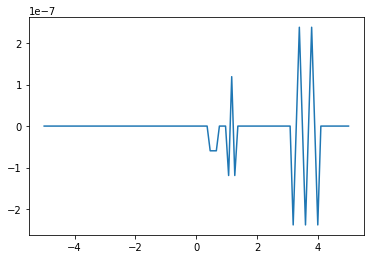

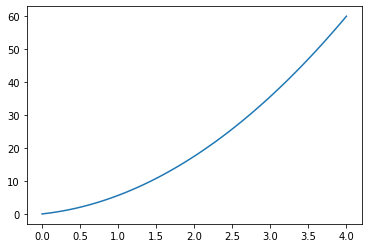

In [37]:
# Example f'(x) - x - 1 = 0, with e.g. f(0) = 0, on domain x in [0,infty)
# Solution f(x) = x^2/2 + x + c, where f(0) = c = 0
def equation1(f, x):
    assert isinstance(x, torch.Tensor), "x must be a Pytorch tensor"
    assert x.requires_grad, "x must have `requires_grad=True`"
    y = f(x)
    f_prime = grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    return f_prime - x - 1


def bc_equation1(x):
    return 0.0

p_test = 0

x_b = 0.0

loss_fn_test = LossFunction(equation1, [p_test], [bc_equation1], [x_b])


def f_analytic(x):
    return x**2 * 0.5 + x


def f_dummy(x):
    return x**2


x_test = torch.linspace(-5, 5, 100, requires_grad=True)
y_test = equation1(f_analytic, x_test)

plt.plot(x_test.detach(), y_test.detach())
plt.show()

plt.plot(np.linspace(0,4,100), f_analytic(np.linspace(0,10,100)))
plt.show()



Initial loss: 3.3062
Epoch 1/1000 Loss: 3.3062
Epoch 2/1000 Loss: 3.2982
Epoch 3/1000 Loss: 3.2900
Epoch 4/1000 Loss: 3.2814
Epoch 5/1000 Loss: 3.2724
Epoch 6/1000 Loss: 3.2629
Epoch 7/1000 Loss: 3.2529
Epoch 8/1000 Loss: 3.2422
Epoch 9/1000 Loss: 3.2309
Epoch 10/1000 Loss: 3.2188
Epoch 11/1000 Loss: 3.2060
Epoch 12/1000 Loss: 3.1924
Epoch 13/1000 Loss: 3.1779
Epoch 14/1000 Loss: 3.1626
Epoch 15/1000 Loss: 3.1464
Epoch 16/1000 Loss: 3.1292
Epoch 17/1000 Loss: 3.1110
Epoch 18/1000 Loss: 3.0918
Epoch 19/1000 Loss: 3.0716
Epoch 20/1000 Loss: 3.0503
Epoch 21/1000 Loss: 3.0279
Epoch 22/1000 Loss: 3.0043
Epoch 23/1000 Loss: 2.9797
Epoch 24/1000 Loss: 2.9539
Epoch 25/1000 Loss: 2.9269
Epoch 26/1000 Loss: 2.8987
Epoch 27/1000 Loss: 2.8692
Epoch 28/1000 Loss: 2.8386
Epoch 29/1000 Loss: 2.8067
Epoch 30/1000 Loss: 2.7737
Epoch 31/1000 Loss: 2.7394
Epoch 32/1000 Loss: 2.7039
Epoch 33/1000 Loss: 2.6672
Epoch 34/1000 Loss: 2.6293
Epoch 35/1000 Loss: 2.5903
Epoch 36/1000 Loss: 2.5501
Epoch 37/1000 Lo

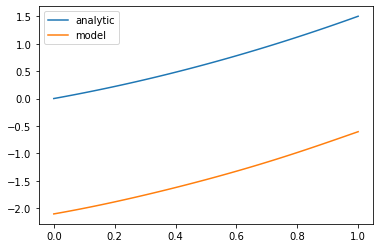

In [38]:
# Domain discretization
discretization_delta = 0.01
x = np.arange(0, 1, discretization_delta)

# Define dataloader
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader_test = DataLoader(x_tensor, batch_size=1000, shuffle=False)

# Define model
hidden_shapes=[200,50,10]
model = DNN(1, hidden_shapes, 1)

# Training parameters
num_epochs = 1000
learning_rate = 0.001
training(model, loss_fn_test, dataloader_test, num_epochs=num_epochs, learning_rate=learning_rate)

# Visual evaluation
model.eval()
x_eval = np.linspace(0,1,100)
y_analytic = f_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

plt.plot(x_eval, y_analytic, label="analytic")
plt.plot(x_eval, y_model, label="model")
plt.legend()
plt.show()

In [12]:
model

DNN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)